In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
fid = drive.ListFile({'q':"title='wood.zip'"}).GetList()[0]['id']
f = drive.CreateFile({'id': fid})
f.GetContentFile('wood.zip')
f.keys()
!unzip "wood.zip"

Streaming output truncated to the last 5000 lines.
  inflating: wood/train/Kathal/131.jpg  
  inflating: wood/train/Kathal/1312.jpg  
  inflating: wood/train/Kathal/1313.jpg  
  inflating: wood/train/Kathal/1315.jpg  
  inflating: wood/train/Kathal/1316.jpg  
  inflating: wood/train/Kathal/1317.jpg  
  inflating: wood/train/Kathal/1319.jpg  
  inflating: wood/train/Kathal/132.jpg  
  inflating: wood/train/Kathal/1320.jpg  
  inflating: wood/train/Kathal/1321.jpg  
  inflating: wood/train/Kathal/1322.jpg  
  inflating: wood/train/Kathal/1323.jpg  
  inflating: wood/train/Kathal/1324.jpg  
  inflating: wood/train/Kathal/1326.jpg  
  inflating: wood/train/Kathal/1327.jpg  
  inflating: wood/train/Kathal/1329.jpg  
  inflating: wood/train/Kathal/133.jpg  
  inflating: wood/train/Kathal/1331.jpg  
  inflating: wood/train/Kathal/1333.jpg  
  inflating: wood/train/Kathal/1334.jpg  
  inflating: wood/train/Kathal/1338.jpg  
  inflating: wood/train/Kathal/1339.jpg  
  inflating: wood/train/Kath

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import numpy as np
from tensorflow import keras

import numpy as np
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import matplotlib.pyplot as plt
%matplotlib inline

print(tf.__version__)

2.13.0


In [ ]:
import tensorflow as tf

# Define the batch size and image size
BATCH_SIZE = 32
IMG_SIZE = (224, 224)  # Change this to your desired image size

# Directory where your dataset is located (replace with your actual path)
dataset_directory = '/content/wood/train'
test_dataset = '/content/wood/test'


# Create a training dataset
train_dataset = tf.keras.utils.image_dataset_from_directory(
    dataset_directory,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    validation_split=0.2,  # Specify the validation split here
    subset="training",
    seed = 66 # This creates the training dataset
)

# Create a validation dataset
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    dataset_directory,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    validation_split=0.2,  # Specify the validation split here
    subset="validation" ,
    seed= 66 # This creates the validation dataset
)

test_dataset = tf.keras.utils.image_dataset_from_directory(test_dataset,
                                                                 shuffle=True,
                                                               batch_size=BATCH_SIZE,
                                                               image_size=IMG_SIZE)


Found 7000 files belonging to 7 classes.
Using 5600 files for training.
Found 7000 files belonging to 7 classes.
Using 1400 files for validation.
Found 175 files belonging to 7 classes.


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = tf.keras.Sequential([
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    layers.RandomContrast(factor=0.2),
    layers.RandomRotation(factor=0.15),  # Randomly rotate images by up to 15 degrees
    layers.RandomZoom(height_factor=0.2, width_factor=0.2),  # Randomly zoom in/out by up to 20%
    layers.RandomFlip(mode="horizontal"),  # Randomly flip images horizontally
    layers.RandomBrightness(factor=0.2),  # Randomly adjust brightness
])



In [ ]:
base_model = keras.applications.VGG19(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(224, 224, 3),
    include_top=False)

In [ ]:
base_model.trainable = False

In [ ]:
base_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
nb_classes = 7
inputs = keras.Input(shape=(224, 224, 3))
#x = data_augmentation(inputs)  # Apply random data augmentation
# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(inputs)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.5)(x)  # Regularize with dropout
x = keras.layers.Dense(512, activation="relu")(x)

outputs = Dense(nb_classes, activation="softmax")(x)
#outputs = keras.layers.Dense(13)(x)
model = keras.Model(inputs, outputs)

In [ ]:
model.compile(optimizer='adam' , loss='sparse_categorical_crossentropy',metrics =['accuracy'])

In [ ]:
epochs = 100
history = model.fit(train_dataset, epochs=epochs, validation_data=validation_dataset)

Epoch 1/100
175/175 [==============================] - 53s 222ms/step - loss: 1.2759 - accuracy: 0.5391 - val_loss: 0.7678 - val_accuracy: 0.7279
Epoch 2/100
175/175 [==============================] - 35s 201ms/step - loss: 0.8316 - accuracy: 0.7005 - val_loss: 0.6070 - val_accuracy: 0.8007
Epoch 3/100
175/175 [==============================] - 36s 206ms/step - loss: 0.7810 - accuracy: 0.7164 - val_loss: 0.5006 - val_accuracy: 0.8307
Epoch 4/100
175/175 [==============================] - 39s 224ms/step - loss: 0.6834 - accuracy: 0.7554 - val_loss: 0.4279 - val_accuracy: 0.8664
Epoch 5/100
175/175 [==============================] - 37s 208ms/step - loss: 0.6483 - accuracy: 0.7629 - val_loss: 0.4034 - val_accuracy: 0.8757
Epoch 6/100
175/175 [==============================] - 37s 212ms/step - loss: 0.6337 - accuracy: 0.7713 - val_loss: 0.3750 - val_accuracy: 0.8750
Epoch 7/100
175/175 [==============================] - 37s 210ms/step - loss: 0.6146 - accuracy: 0.7734 - val_loss: 0.3633 -

In [ ]:
scores = model.evaluate(test_dataset)

6/6 [==============================] - 4s 708ms/step - loss: 0.0269 - accuracy: 0.9886


In [ ]:
class_names = train_dataset.class_names
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 26ms/step


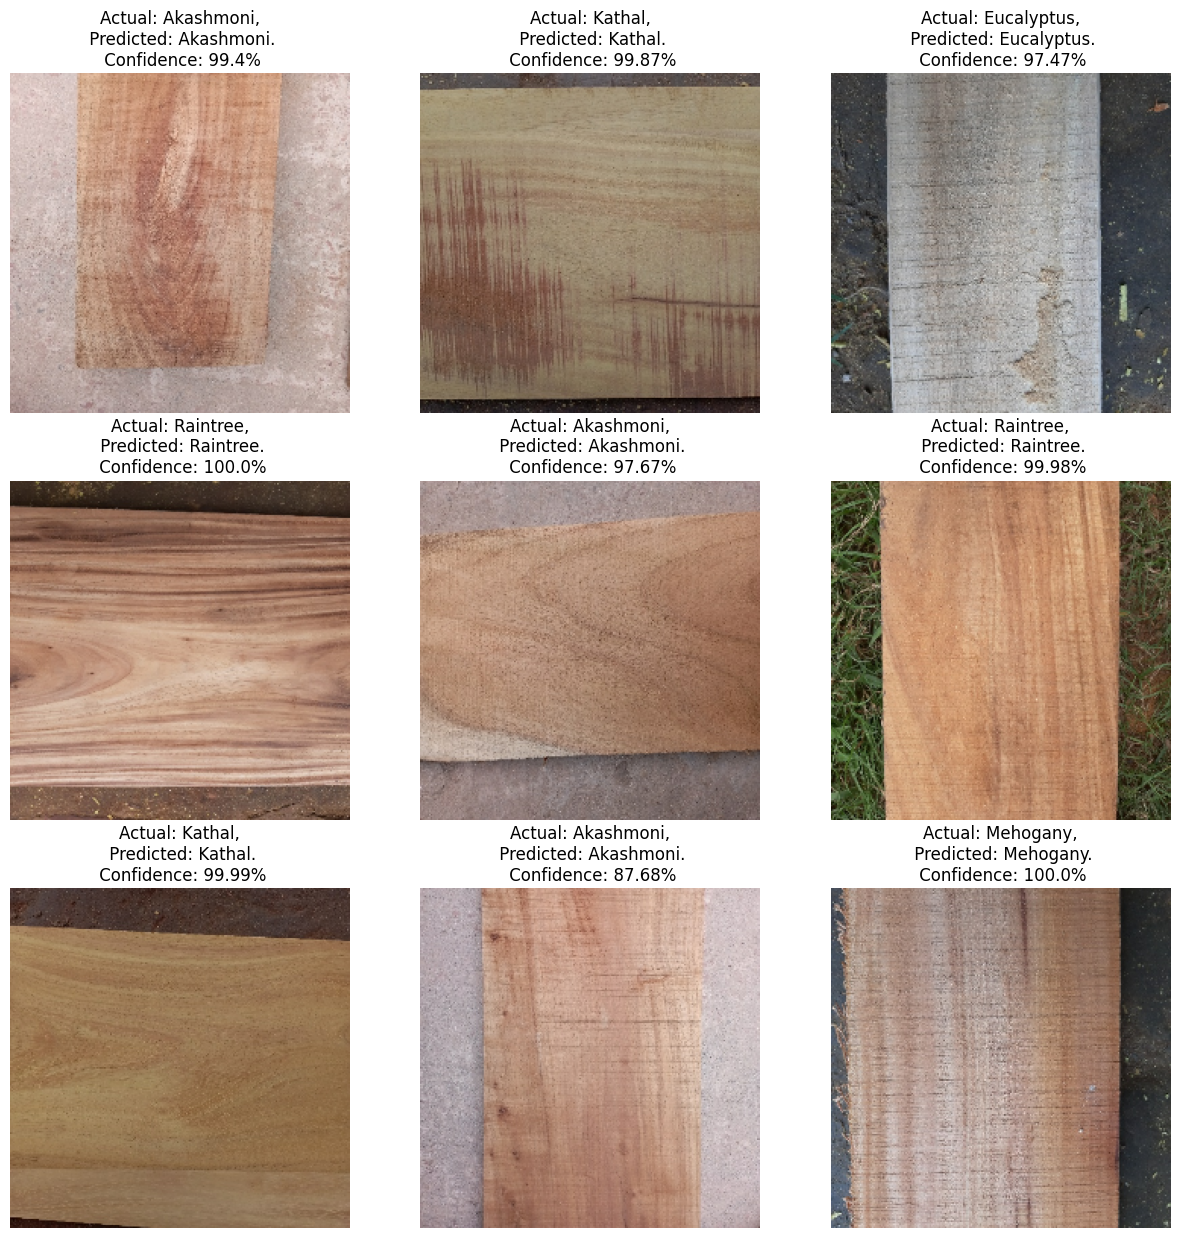

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

1/1 [==============================] - 0s 35ms/step


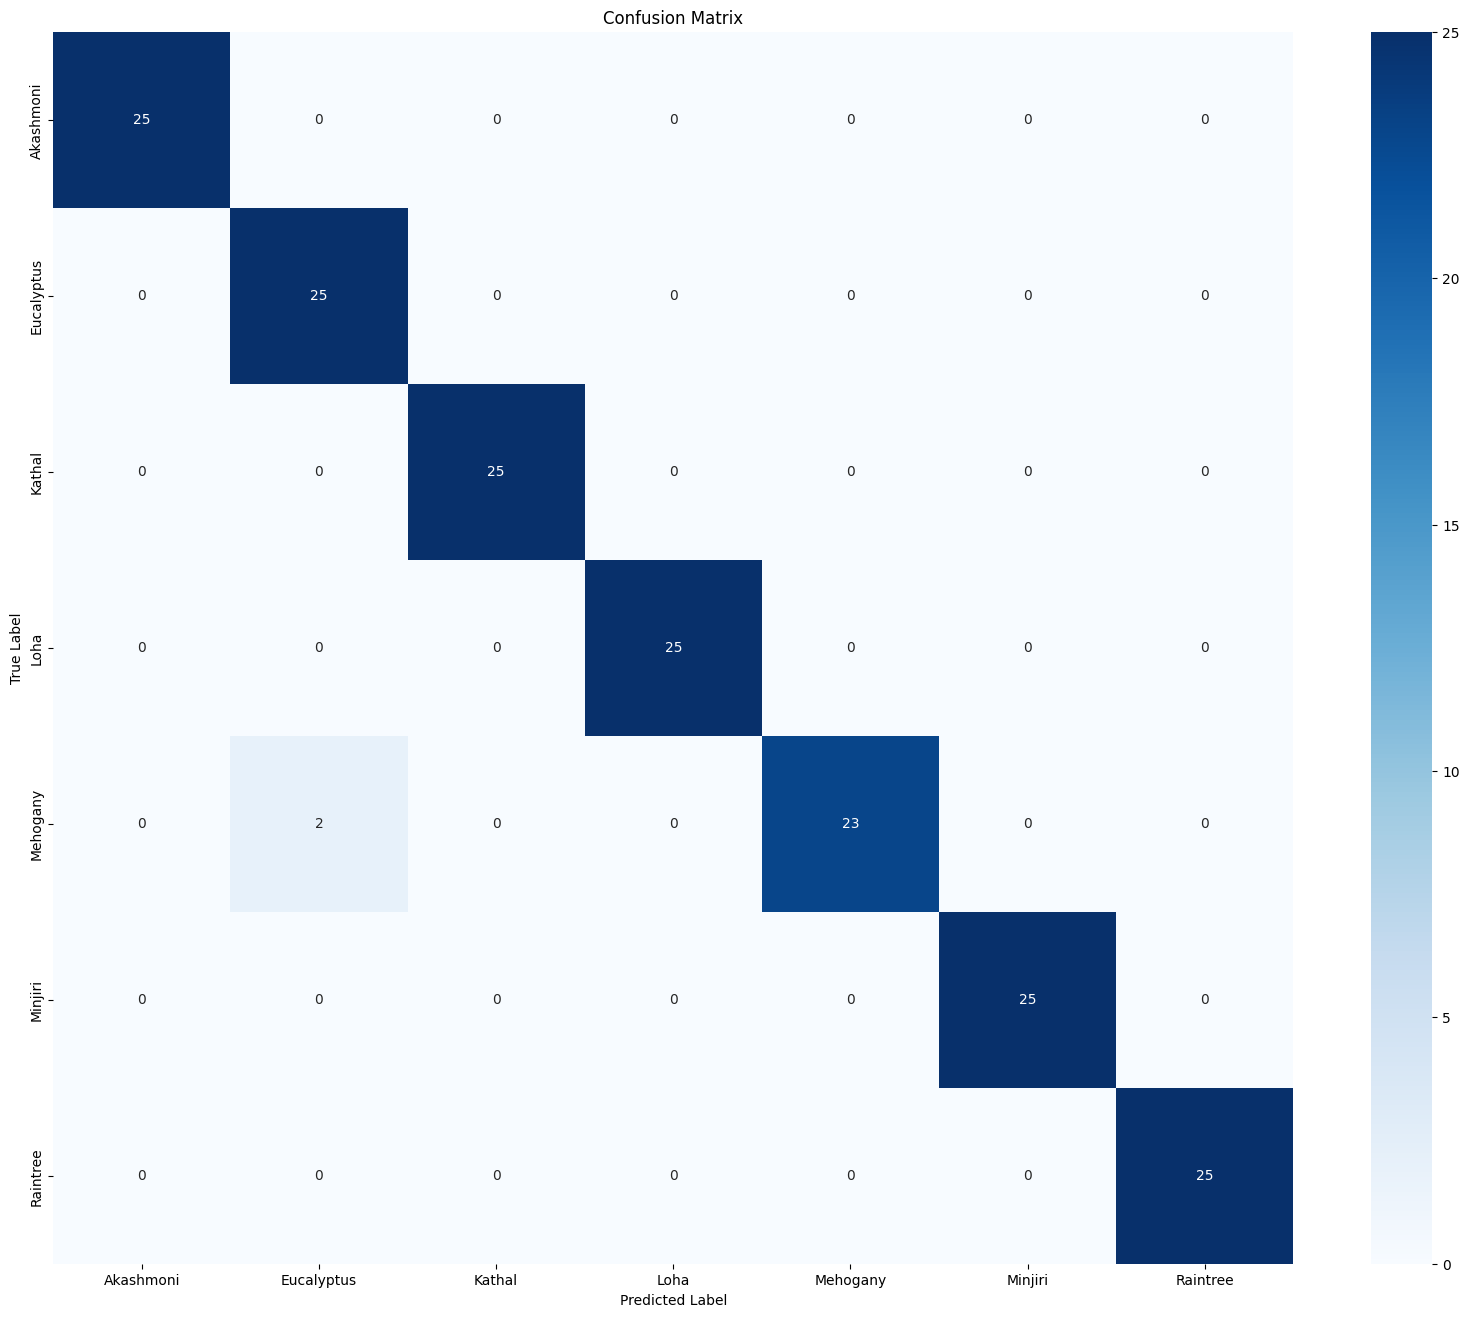

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Replace 'Class 0' and 'Class 1' with the actual class names from your dataset
class_names = test_dataset.class_names

# Create empty arrays to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Iterate through the validation dataset to obtain true and predicted labels
for images, labels in test_dataset:
    predictions = model.predict(images)
    predicted_labels.extend(np.argmax(predictions, axis=1))
    true_labels.extend(labels.numpy())

# Calculate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Create a heatmap using seaborn
plt.figure(figsize=(20, 16))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=class_names, yticklabels=class_names)

# Add a title and axis labels
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Show the plot
plt.show()

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

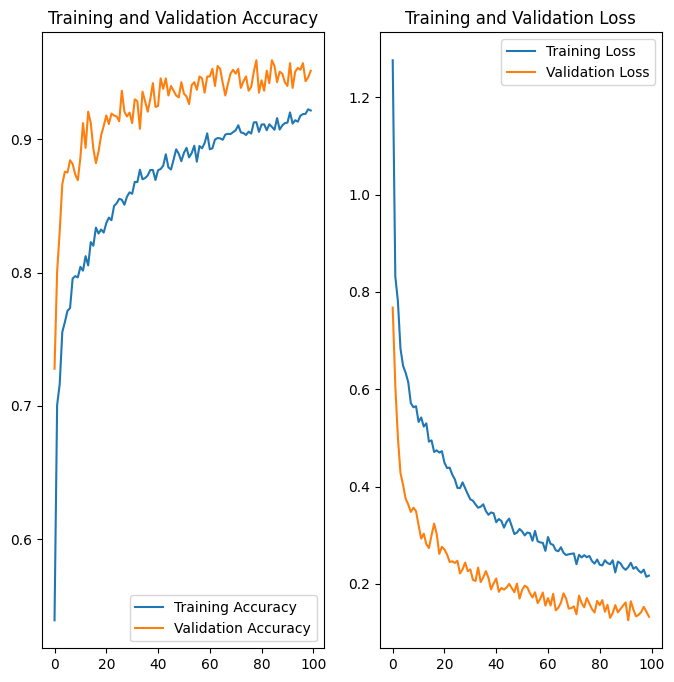

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(epochs), acc, label='Training Accuracy')
plt.plot(range(epochs), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(epochs), loss, label='Training Loss')
plt.plot(range(epochs), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

1/1 [==============================] - 0s 32ms/step


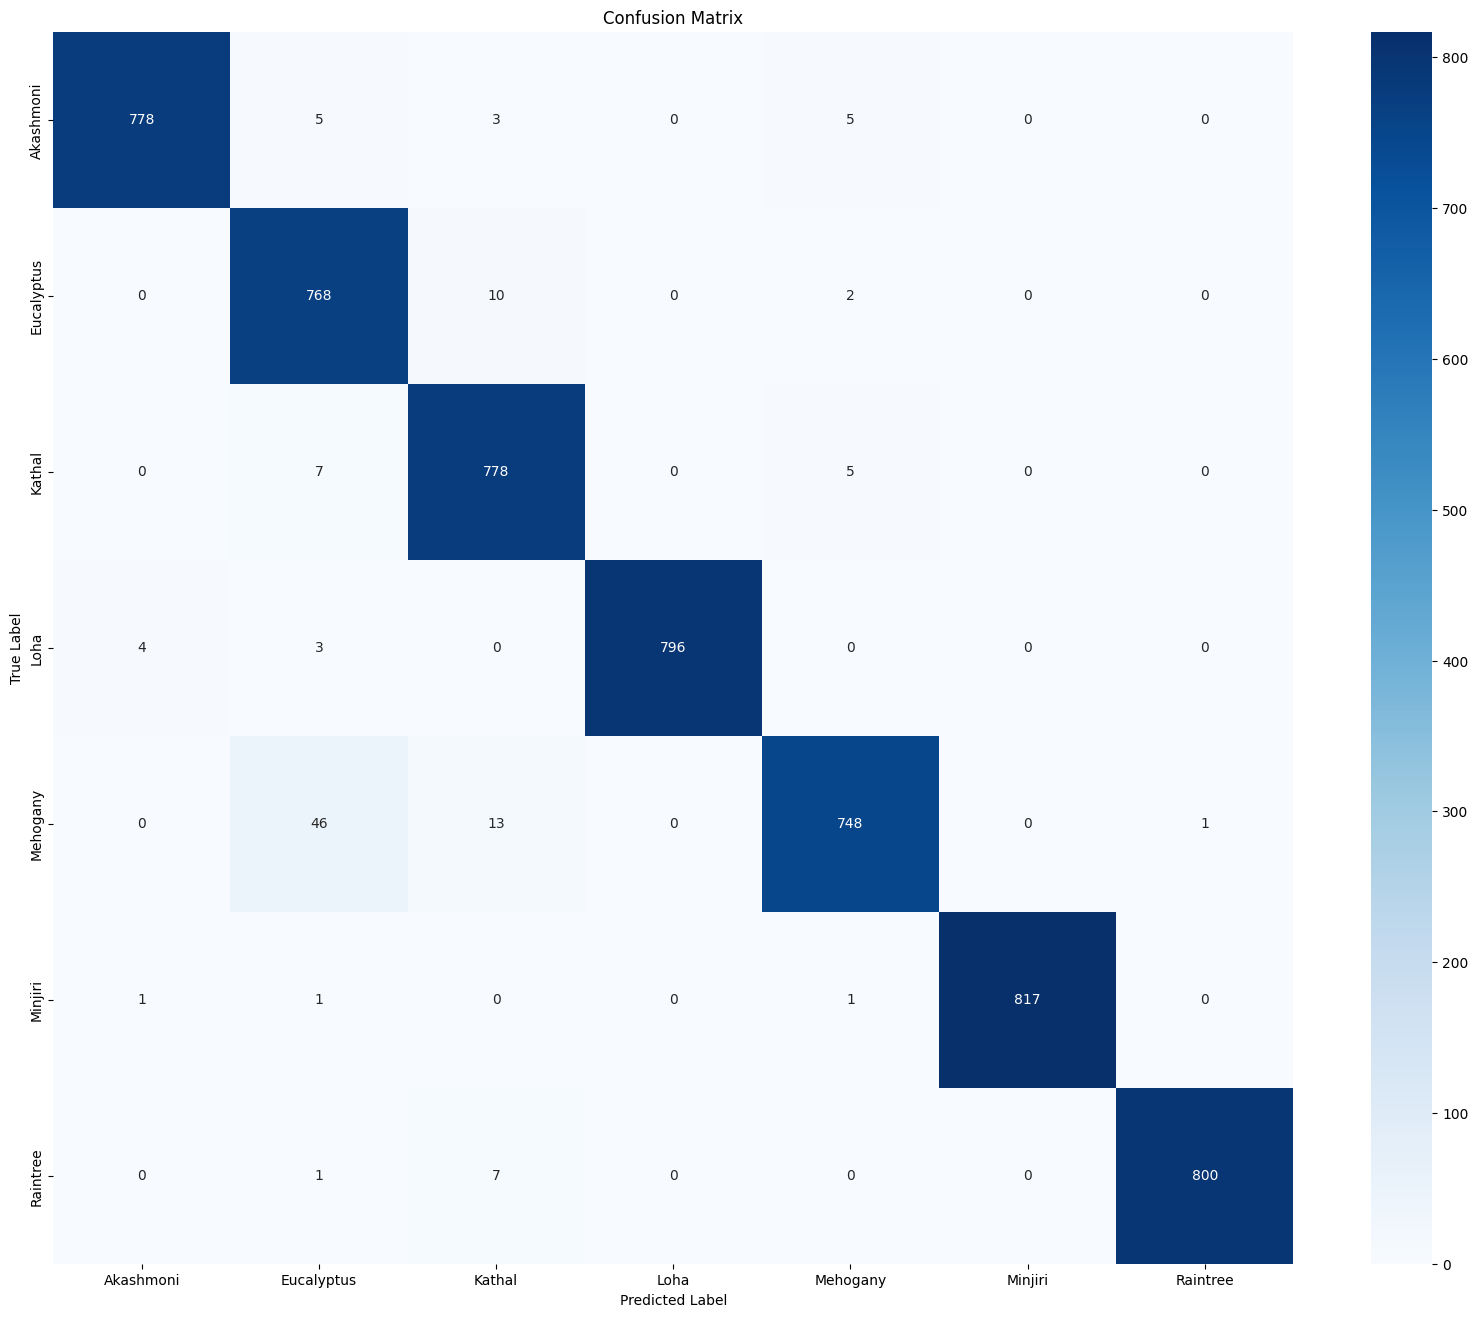

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Replace 'Class 0' and 'Class 1' with the actual class names from your dataset
class_names = train_dataset.class_names

# Create empty arrays to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Iterate through the validation dataset to obtain true and predicted labels
for images, labels in train_dataset:
    predictions = model.predict(images)
    predicted_labels.extend(np.argmax(predictions, axis=1))
    true_labels.extend(labels.numpy())

# Calculate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Create a heatmap using seaborn
plt.figure(figsize=(20, 16))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=class_names, yticklabels=class_names)

# Add a title and axis labels
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Show the plot
plt.show()

1/1 [==============================] - 0s 23ms/step
F1 Score: 0.9524984575512402
Precision: 0.95528306418223
Recall: 0.9513928523445098
ROC-AUC Score: 0.9984128192113355


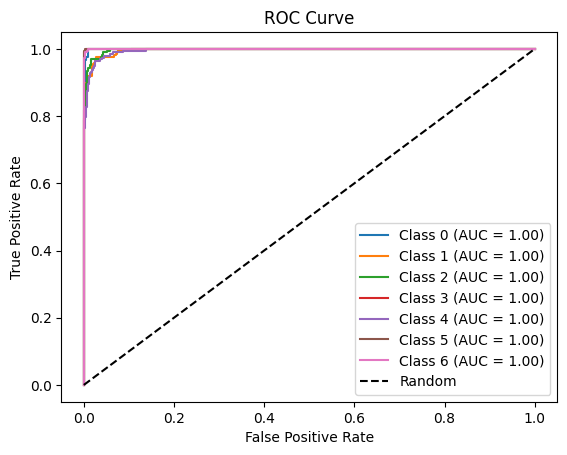

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt


# After model.fit(...)
validation_dataset = validation_dataset.unbatch().batch(1)  # Batch size = 1 for individual predictions

y_true = []
y_pred = []

for x_val, y_val in validation_dataset:
    y_true.append(y_val.numpy()[0])  # Append true labels
    y_pred.append(model.predict(x_val)[0])  # Append predicted probabilities (raw output)

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Convert predicted probabilities to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate the metrics
f1 = f1_score(y_true, y_pred_classes, average='macro')
precision = precision_score(y_true, y_pred_classes, average='macro')
recall = recall_score(y_true, y_pred_classes, average='macro')
roc_auc = roc_auc_score(y_true, y_pred, multi_class='ovo')

print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"ROC-AUC Score: {roc_auc}")

# Plot ROC curves (only for binary classification or when using one-hot encoded labels)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(nb_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true == i, y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
for i in range(nb_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()
